<a href="https://colab.research.google.com/github/Alexey1998-ml/example/blob/master/catch_me.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [0]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score,\
learning_curve, TimeSeriesSplit
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import torch
import torch.nn as nn
from IPython.display import clear_output

In [0]:
test = pd.read_csv('drive/My Drive/catch_me_test_sessions.csv')
data = pd.read_csv('drive/My Drive/catch_me_train_sessions.csv')
times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]

In [0]:
class Prepare:
  def __init__(self, train, test, target_column : str = 'target', **kwargs):
    self.train = train
    self.target_column = target_column
    self.target = train[target_column]
    self.test = test
    self.unknown_idx = -1
    self.pad_idx = 0
    self.test_size = 0.15
    self.batch_size = 1024

  def prepare_df (self):
    train = self.train
    test = self.test
    train[times] = train[times].apply(pd.to_datetime)
    test[times] = test[times].apply(pd.to_datetime)
    train[sites] = train[sites].fillna(self.pad_idx).astype(int)
    train = train.sort_values('time1')
    self.train = train
    self.test = test
  
  def _get_known_sites(self, train, number_sites = 5000):
      counter = Counter()
      alice_sites = Counter()
      for site in sites:
        for num_site in train[site]:
          counter.update({num_site})
      for site in sites:
        for num_site in train[train['target'] == 1][site]:
          alice_sites.update({num_site})
      known_sites = [site for site, counts in dict(counter.most_common(number_sites)).items()]
      known_sites += [site for site, counts in alice_sites.items()]
      known_sites += [self.pad_idx, self.unknown_idx]
      known_sites = set(known_sites)
      sites_to_id = {site : inx for inx, site in enumerate(known_sites)}
      return sites_to_id

  def get_df_for_train(self):
    train_df, valid_df, train_target, valid_target = train_test_split(self.train, self.target, random_state = 42,
                                                                      shuffle = False, test_size = self.test_size)
    sites_to_id = self._get_known_sites(train_df)
    self.sites_to_id = sites_to_id
    train_df[sites] = train_df[sites].applymap(lambda num_site: sites_to_id[num_site] if num_site in sites_to_id 
                                               else sites_to_id[self.unknown_idx])
    valid_df[sites] = valid_df[sites].applymap(lambda num_site: sites_to_id[num_site] if num_site in sites_to_id 
                                               else sites_to_id[self.unknown_idx])
    return train_df, valid_df
  

In [0]:
class TrainNN(Prepare):
    def make_batch (self, df, dropout = 0, **kwargs):

      batch = {}
      batch['sites'] = df[sites].values
      if dropout > 0:
        batch['sites'] = self._apply_word_dropout(batch['sites'], dropout)
      batch[self.target_column] = df[self.target_column].values
      return batch

    def _apply_word_dropout (self, matrix, keep_prop, replace_with = -1, pad_ix = 0):
      dropout_mask = np.random.choice(2, matrix.shape, p = [1 - keep_prop, keep_prop])
      dropout_mask &= matrix !=  pad_ix
      return np.choose (dropout_mask, [matrix, np.full_like(matrix, replace_with)])
    
    def iterable_minibatches (self, data, shuffle = True, **kwargs):
      if 'prob' in kwargs.keys():
        prob = kwargs['prob']
      else:
        prob = 1
      indecses = np.arange(len(data))
      if shuffle:
        indecses = np.random.permutation(indecses)
      for start in range(0, len(indecses), self.batch_size):
        is_take = np.random.choice(2, size = 1, p = [1 - prob, prob])[0]
        if is_take == 0:
          yield None, None
          continue
        batch = self.make_batch(data.iloc[indecses[start : start + self.batch_size]], **kwargs)
        target = batch.pop(self.target_column)
        yield batch, target

In [0]:
trainer = TrainNN(data, test)

In [0]:
trainer.prepare_df()

In [0]:
train_df, valid_df = trainer.get_df_for_train()

In [0]:
class Reorder(nn.Module):
  def forward (self, input):
    return input.permute(0, 2, 1)

class Flatten (nn.Module):
  def forward(self, input):
    return input.view(input.size(0),-1)

In [0]:
class NN(nn.Module):
  def __init__(self, n_tokens = len(trainer.sites_to_id), hid_size = 64, 
               len_sequence = 10):
    super(NN, self).__init__()
    self.emb = nn.Embedding(n_tokens, hid_size)
    self.reorder = Reorder()
    self.cnn1 = nn.Conv1d(in_channels = hid_size,
                         out_channels = hid_size,
                         kernel_size = 3)
    self.cnn2 = nn.Conv1d(in_channels = hid_size,
                         out_channels = hid_size,
                         kernel_size = 2)
    self.cnn3 = nn.Conv1d(in_channels = hid_size,
                         out_channels = hid_size,
                         kernel_size = 4)
    self.relu = nn.ReLU()
    self.maxpool = nn.AdaptiveAvgPool1d(1)
    self.flatten = Flatten()
    self.fc1 = nn.Linear(3*hid_size, hid_size)
    self.fc2 = nn.Linear(hid_size, 1)
    self.sigmoid = nn.Sigmoid()
    self.dropout_emb = nn.Dropout2d(0.4)
    self.batchnorm = nn.BatchNorm1d(3*hid_size)
    self.dropout = nn.Dropout(0.4)

  def forward(self, input):
    emb = self.emb(input)
    emb = self.dropout_emb(emb)
    emb = self.reorder(emb)
    cnn1 = self.relu(self.cnn1(emb))
    cnn2 = self.relu(self.cnn2(emb))
    cnn3 = self.relu(self.cnn3(emb))
    pool1 = self.maxpool(cnn1)
    pool2 = self.maxpool(cnn2)
    pool3 = self.maxpool(cnn3)
    flatten1 = self.flatten(pool1)
    flatten2 = self.flatten(pool2)
    flatten3 = self.flatten(pool3)
    flatten = torch.cat([flatten1.view(flatten1.size(0), -1),
                         flatten2.view(flatten2.size(0), -1),
                         flatten3.view(flatten3.size(0), -1)], dim = 1)
    flatten = self.batchnorm(flatten)
    flatten = self.dropout(flatten)
    out = self.fc1(flatten)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.sigmoid(out)
    return out


In [0]:
model = NN()
device = torch.device("cuda:0")
model.to(device)

NN(
  (emb): Embedding(5364, 64)
  (reorder): Reorder()
  (cnn1): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (cnn2): Conv1d(64, 64, kernel_size=(2,), stride=(1,))
  (cnn3): Conv1d(64, 64, kernel_size=(4,), stride=(1,))
  (relu): ReLU()
  (maxpool): AdaptiveAvgPool1d(output_size=1)
  (flatten): Flatten()
  (fc1): Linear(in_features=192, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout_emb): Dropout2d(p=0.4, inplace=False)
  (batchnorm): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [0]:
batch, target = next(trainer.iterable_minibatches(train_df))
input = torch.tensor(batch['sites'], dtype=torch.long).cuda()

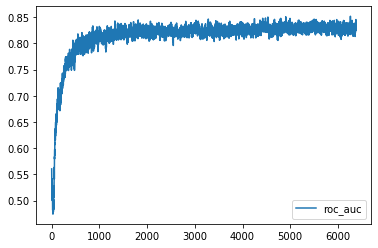

val 0.8302932372942893



KeyboardInterrupt: ignored

In [0]:
history_train = []
history_val = []
epochs = 300
optim = torch.optim.Adam(model.parameters())
loss_function = nn.BCELoss().to(device)

for epoch in range(epochs):
  for idx, (batch, target) in tqdm_notebook(enumerate(trainer.iterable_minibatches(train_df))):
    # Preprocessing the batch data and target
    input1 = torch.tensor(batch['sites'], dtype=torch.long).cuda()
    target = torch.tensor(target).float().to(device)

    predictions = model(input1).float()
    predictions = predictions.view(predictions.size(0))
    loss = loss_function(predictions, target)

    loss.backward()
    optim.step()
    optim.zero_grad()

   
    history_train.append(loss.data.cpu().numpy())
    history_val.append(roc_auc(model, valid_df))
    if (idx+1)%50==0:
        clear_output(True)
        # plt.plot(history_train,label='train loss')
        plt.plot(history_val,label='roc_auc')
        plt.legend()
        plt.show()
        # print(f'train {loss}')
        print(f'val {history_val[-1]}')

In [0]:
def roc_auc (model, data, target = 'target'):
  roc_auc = roc_auc_score(data[target],
                          model(torch.tensor(trainer.make_batch(valid_df)['sites'], dtype=torch.long).cuda()).cpu().data.numpy())
  return roc_auc